In [19]:
import json
import os
from collections import Counter, defaultdict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import random
import cv2

# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
import io

In [20]:
dataset_path = "./whos_waldo"


def get_names(path, file_name, is_json=False):
    if not is_json: 
        return list(map(lambda x: x.strip(),open(os.path.join(path, file_name)).readlines()))
    
    res_json = json.load(open(os.path.join(path, file_name)))
    return list(res_json.keys())


In [21]:
meta_path = './dataset_meta/splits'

train_files = get_names(meta_path, 'train.txt')
val_files = get_names(meta_path, 'val.txt')
test_files = get_names(meta_path, 'test.txt')

In [22]:
print(f'Train size: {len(train_files)}')
print(f'Val size: {len(val_files)}')
print(f'Test size: {len(test_files)}')


Train size: 73812
Val size: 5000
Test size: 5000


In [23]:
def get_detections_dict(path, names):
    detections_dict = defaultdict(list)
    for name in tqdm(names):
        data = json.load(open(os.path.join(path, name, 'detections.json')))
        detections_dict[len(data)].append(name)
    return detections_dict

def get_ground_truth_dict(path, names):
    detections_dict = defaultdict(list)
    for name in tqdm(names):
        data = json.load(open(os.path.join(path, name, 'ground_truth.json')))
        detections_dict[len(data)].append(name)
    return detections_dict

def get_detections_df(path, names):
    res = []
    for name in tqdm(names):
        data = json.load(open(os.path.join(path, name, 'detections.json')))
        res.append((name, len(data)))
    return pd.DataFrame(res, columns=['name', 'count'])

def get_ground_truth_df(path, names):
    res = []
    for name in tqdm(names):
        data = json.load(open(os.path.join(path, name, 'ground_truth.json')))
        res.append((name, len(data)))
    return pd.DataFrame(res, columns=['name', 'count'])

In [24]:
file_names = val_files + train_files + test_files
# dets_dict = dict(sorted(get_detections_dict(dataset_path, file_names).items(), key=lambda item: item[0]))
# gts_dict = dict(sorted(get_ground_truth_dict(dataset_path, file_names).items(), key=lambda item: item[0]))

csv_path = './dataset_meta/csv'

def export_meta_data():
    get_detections_df(dataset_path, file_names).to_csv(os.path.join(csv_path, 'dets_df.csv'), index=False)
    get_ground_truth_df(dataset_path, file_names).to_csv(os.path.join(csv_path, 'gts_df.csv'), index=False)

# export_meta_data()

In [25]:
dets_df = pd.read_csv(os.path.join(csv_path, 'dets_df.csv'), dtype=str)
gts_df = pd.read_csv(os.path.join(csv_path, 'gts_df.csv'), dtype=str)

dets_df['count'] = dets_df['count'].astype(int)
gts_df['count'] = gts_df['count'].astype(int)

<AxesSubplot: xlabel='count', ylabel='count'>

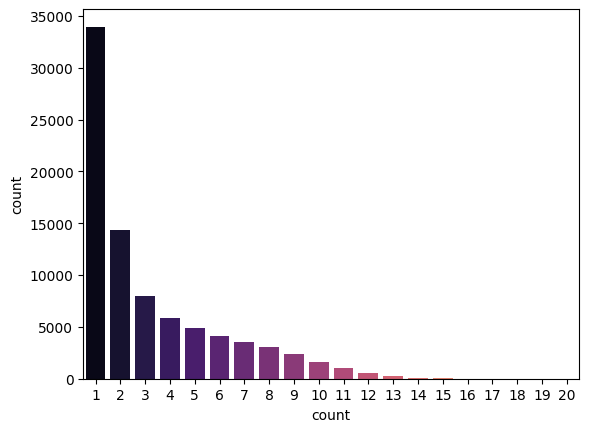

In [26]:
seaborn.countplot(data=dets_df, x='count', palette = 'magma')

<AxesSubplot: xlabel='count', ylabel='count'>

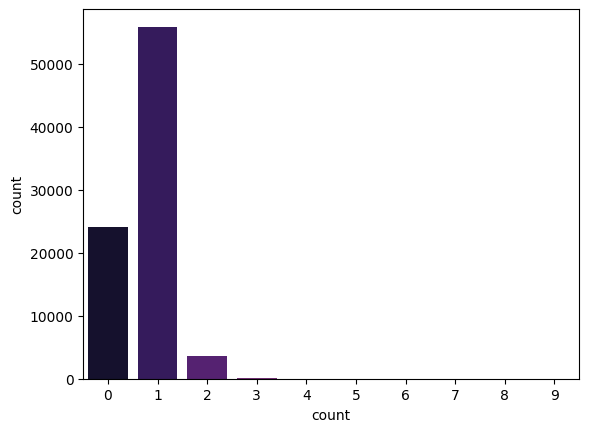

In [27]:
seaborn.countplot(data=gts_df, x='count', palette = 'magma')

In [28]:
dets_dict = dets_df.groupby('count').apply(lambda g: list(map(lambda x: x[0], g.values.tolist()))).to_dict()
gts_dict = gts_df.groupby('count').apply(lambda g: list(map(lambda x: x[0], g.values.tolist()))).to_dict()

In [29]:
def sampling_from(dt, cnt):
    name = random.sample(dt[cnt], 1)[0]
    folder = os.path.join(dataset_path, name)
    return {
        'name': name,
        'caption': list(map(lambda x: x.strip(),open(os.path.join(folder, 'caption.txt')).readlines()))[0],
        'coreferences': json.load(open(os.path.join(folder, 'coreferences.json'))),
        'detections': list(map(lambda x: x['bbox'], json.load(open(os.path.join(folder, 'detections.json'))))),
        'ground_truth': json.load(open(os.path.join(folder, 'ground_truth.json'))),
        'image': cv2.imread(os.path.join(folder, 'image.jpg'))
    }

In [30]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [31]:
def get_boxes(norm_boxes, img):
    boxes = []
    
    for norm_box in norm_boxes:
        h, w = img.shape[:2]
        box = [norm_box[0] * w, norm_box[1] * h, norm_box[2] * w, norm_box[3] * h]
        box = list(map(lambda x: int(x), box))
        boxes.append(box)
        
    return boxes

In [33]:
def show_sample(sample):
    print('Name: ' + sample['name'])
    print()
    
    print("Caption: ")
    print(sample['caption'])
    print()

    print('Coreferences: ' + str(sample['coreferences']))
    print()

    print('Ground Truth: ' + str(sample['ground_truth']))
    print()
    
    im_rgb = cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB)
    boxes = get_boxes(sample['detections'], sample['image'])
    print(f'img shape: {im_rgb.shape}')
    print(boxes)
    for box in boxes:
        im_rgb = cv2.rectangle(im_rgb, (box[0], box[1]), (box[2], box[3]), list(np.random.random(size=3) * 256), 4)
    showarray(im_rgb)

Name: 158101

Caption: 
[NAME] winning the bronze medal at the Triathlon di Andora (Italy) 2010

Coreferences: [[[0, 6]]]

Ground Truth: {'0': 0}

img shape: (3200, 1433, 3)
[[170, 112, 1278, 3142]]


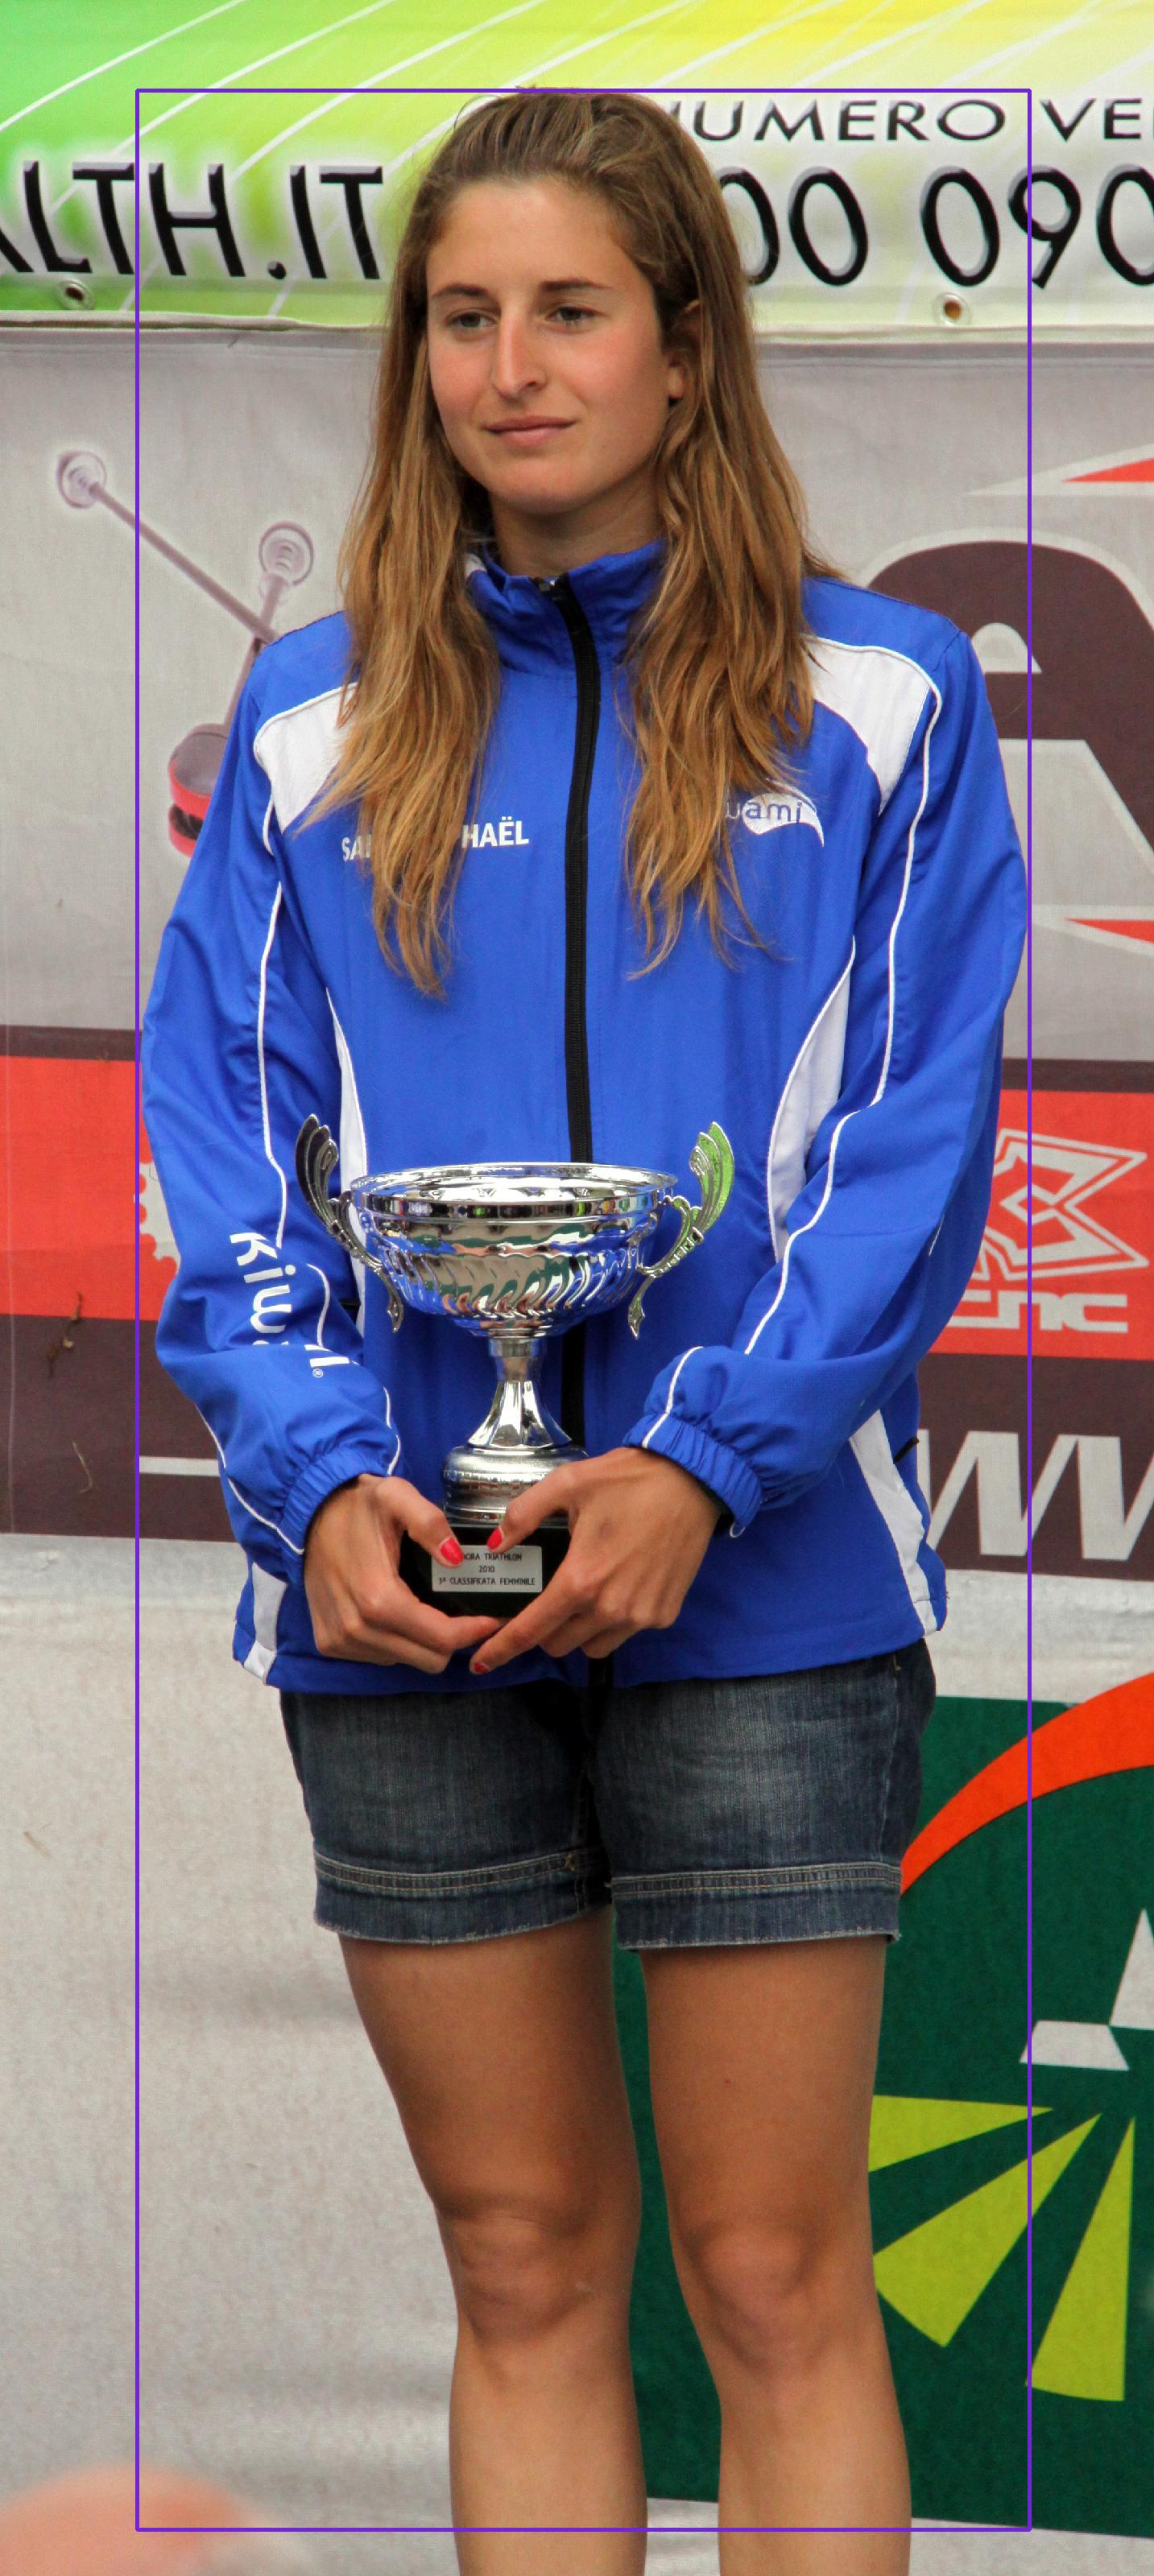

In [65]:
sample = sampling_from(dets_dict, 1)
show_sample(sample)